# MPAL1

Karyotype/Cytogenetics:
```
45,XY,del(6)(q13q21),-7,-8,-9,add(16)(p13),+2mar[cp19]/
46,XY[1]
```
Explanation (ref. https://en.wikipedia.org/wiki/Cytogenetic_notation): 
- 19 cells are coposite (mixed up), with a deletion of chromosome 7, 8, and 9 (i.e., only one copy of 7, 8, and 9 are left). A small deletion on 6 and a addition on 16. A portion of 2 is shown.
- 1 cell is normal (i.e., it has two copies of each chromosome, except for XY).

Thus, we expect to see bimodal distribution on Chr7, 8, and 9.

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Relative Number

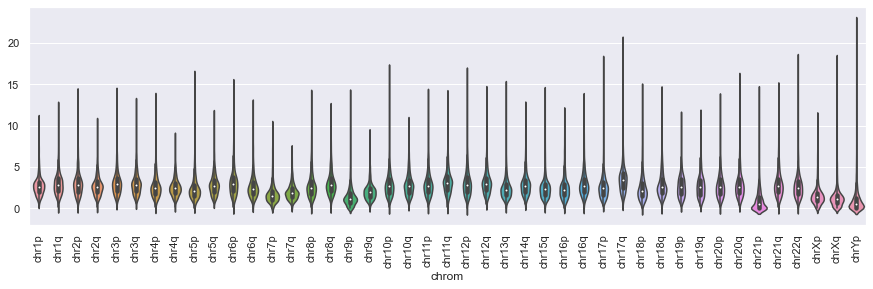

In [7]:
cnv_df_copyscat_relative = pd.read_csv("results/GSM4138898_scATAC_MPAL1_T1_intermediate0.csv", index_col=0).T
sns.set(rc={'figure.figsize':(15,4)})
g = sns.violinplot(data=cnv_df_copyscat_relative)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
pass # suppress output

## CopyscAT produced absolute number

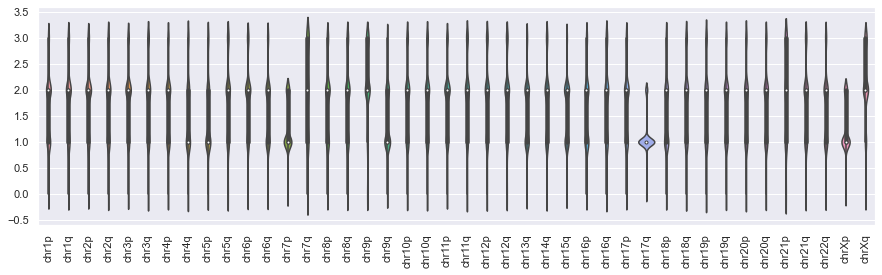

In [8]:
cnv_df_copyscat_absolute = pd.read_csv("results/GSM4138898_scATAC_MPAL1_T1_intermeiate1.csv", index_col=0)
sns.set(rc={'figure.figsize':(15,4)})
g = sns.violinplot(data=cnv_df_copyscat_absolute)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
pass # suppress output

## Investigate chr7p

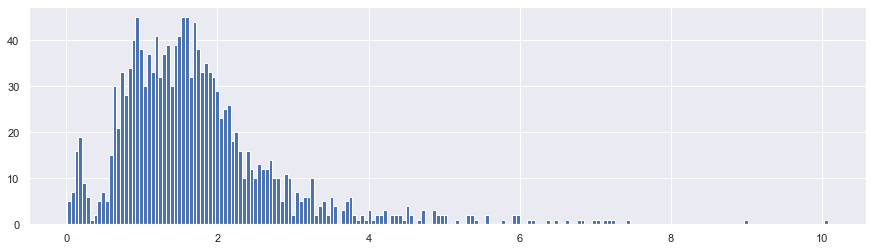

In [9]:
cnv_df_copyscat_relative.chr7p.hist(bins=200)

## Fourier transform of deterministic signal
$\delta(\bullet)$ is Dirac delta (impulses). It is a generalized (i.e., strange) function with following properties
$$\delta(x) = \begin{equation}
\left\{ 
  \begin{aligned}
    &\infty, &x = 0\\
    &0, &\text{otherwise}
  \end{aligned}
  \right.
\end{equation}$$

$$\int_{-\infty}^\infty \delta(x) dx = 1$$

$$f*\delta = \int_{-\infty}^\infty f(s)\delta(x - s) ds = f(x)$$

Our signal is defined as a series of delta functions.
$$f(x) = \sum_i\delta(x-x_i)$$

The continous time Fourier transform is defined as
$$F(\omega)=\mathcal{F}_x[f(x)](\omega)=\int_{-\infty}^{\infty}f(x)e^{i\omega x}$$

Thus, the transformation of our signal can be written as
$$F(\omega)=\mathcal{F}_x[\sum_i\delta(x-x_i)](\omega)=\sum_i\mathcal{F}_x[\delta(x-x_i)](\omega)=\sum_ie^{i\omega x_i}$$


It is the frequency domain representation (spectrum) of our signal. We show the spetrum by finding its value at a list of frequencies, and plot it.

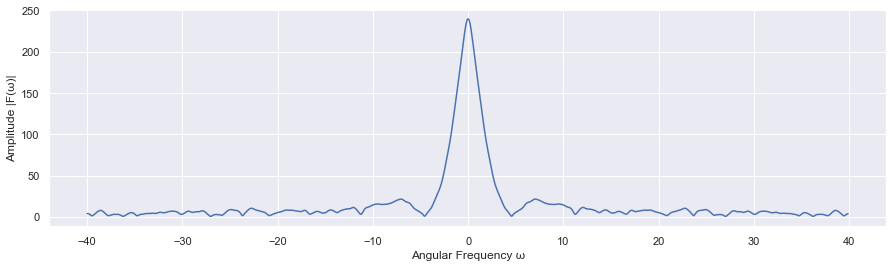

In [10]:
w_list = np.arange(-40, 40, 0.1)
y_list = (np.exp(1j * w_list.reshape([-1, 1]) * cnv_df_copyscat_relative.chr7p.to_numpy().reshape([1, -1]))).sum(axis=1) / (2 * np.pi)

# We need to take abs because the transformed signal is complex. Here we care about its magnitude.
y_list = abs(y_list)
    
plt.plot(w_list, y_list)

plt.xlabel("Angular Frequency ω")
plt.ylabel("Amplitude |F(ω)|")
pass

By default, the transformation gives us angular frequency. We divide it by $2\pi$ to obtain the frequency.

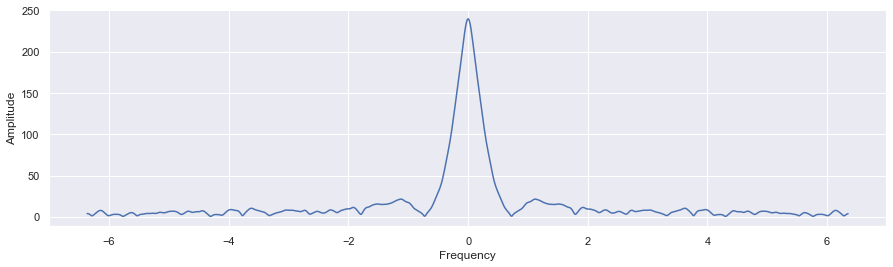

In [11]:
plt.plot(w_list / (2 * np.pi), y_list)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
pass

We can also take the reciprocal of the frequency to get the period, although the graph would look a bit strange. That said, we can overlay it with our histograph now.

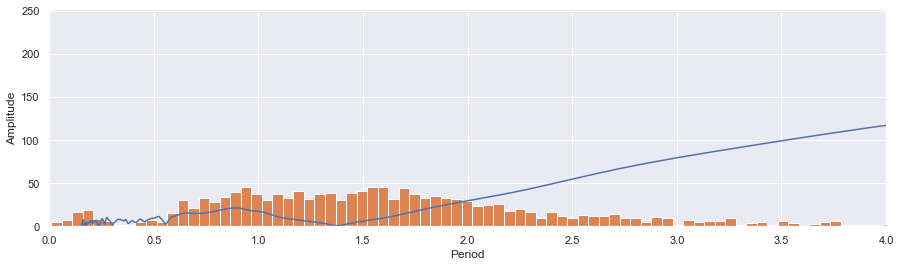

In [12]:
plt.plot((2 * np.pi) / w_list[w_list > 0], y_list[w_list > 0])
plt.xlim([0, 4])
plt.xlabel("Period")
plt.ylabel("Amplitude")
cnv_df_copyscat_relative.chr7p.hist(bins=200)
pass

## Smoothing + FFT (Fast Fourier transform)

The previous analysis are based on continuous Fourier transform

Now we try to smooth the signal to obtain a evenly sampled signal, using a Gaussian kernel $\varphi$ (variance of choice; omitted for simplicity).
$$g(x) = f*\varphi = \int_{-\infty}^\infty f(s)\varphi(x-s) ds$$
$$g(x) = f*\varphi = \int_{-\infty}^\infty \sum_i\delta(s-x_i)\varphi(x-s) ds = \sum_i \varphi(x-x_i)$$

So it's basically adding up Gaussian PDFs located at each of the impulses.

In fact, one way to understand dirac delta is to imagine it as $\delta(x) = \lim_{a \rightarrow \infty}a\varphi(ax)$. Recall the properties we see above. It should be more relatable now.

$$\delta(0) = \infty$$

$$\delta(x) = 0 \text{ if } x \neq 0$$

$$\int_{-\infty}^\infty \delta(x) dx = 1$$

$$f*\delta = \int_{-\infty}^\infty f(s)\delta(x - s) ds = f(x)$$

After doing FFT, we can decompose the signal in the frequency domain and separate the signal into high and low frequency parts.

Text(0.5, 1.0, 'Frequency domain signal')

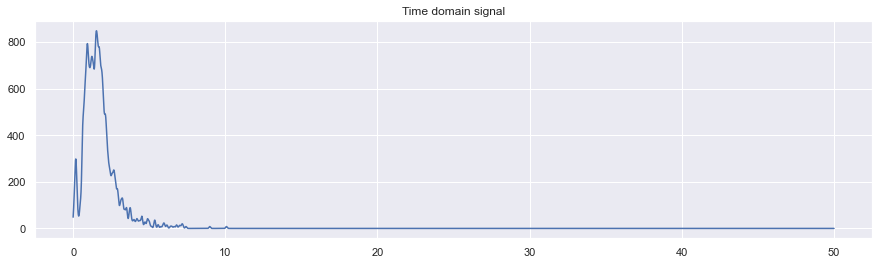

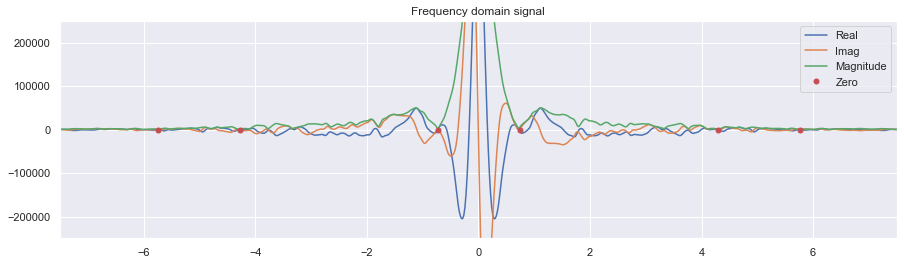

In [41]:
import scipy.stats
n_samples = 20001
xlim = [0, 50]
sampling_rate = n_samples / (xlim[1] - xlim[0])

x = np.linspace(*xlim, n_samples).reshape([-1, 1])
smoothed_signal = scipy.stats.norm.pdf(x, cnv_df_copyscat_relative.chr7p.to_numpy().reshape([1, -1]), 0.05).sum(axis=1)
plt.plot(x, smoothed_signal)
plt.title("Time domain signal")

n_fft = 20001
y = np.fft.fft(smoothed_signal, n_fft)
shifted_y = np.fft.fftshift(y)
shifted_freq = np.arange(- (n_fft // 2), (n_fft // 2) + (n_fft % 2)) * (sampling_rate / n_fft)
plt.figure()
plt.plot(shifted_freq, shifted_y.real)
plt.plot(shifted_freq, shifted_y.imag)
plt.plot(shifted_freq, np.abs(shifted_y))

y_zero = ((shifted_y.real[:-1] < 0) != (shifted_y.real[1:] < 0)) & ((shifted_y.imag[:-1] < 0) != (shifted_y.imag[1:] < 0))
shifted_freq[np.hstack([False, y_zero])]

zero_points = shifted_freq[np.hstack([False, y_zero])]
plt.plot(zero_points, np.zeros(zero_points.shape), 'o', ms=5)
plt.legend(['Real', 'Imag', 'Magnitude', "Zero"])
plt.xlim(-7.5, 7.5)
plt.ylim(-250000, 250000)
plt.title("Frequency domain signal")

In [15]:
n = len(smoothed_signal)
n

20001

# Compress sensing

The original problem of compress sensing is:
$$y = C\Phi s\text{,}$$
where $y$ is the observation, which is usually only available at a small collection of time specified by the mask $C$. $\Phi s$ is the original signal, where $\Phi$ is the discrete Fourier transform matrix (recall that DFT/FFT is simply a change of basis), and $s$ is the strength of each Fourier component.

In practice, discrete cosine transform is used instead to eliminate imaginary numbers.

Given the sparsity of $C$, this is an underdetermined system. We usually find the $s$ that is sparse.
$$\min_s \Vert y - C\Phi s\Vert_2 + \Vert s \Vert_1$$ or $$\min_s \Vert s \Vert_1 \text{ s.t. } \Vert y - C\Phi s\Vert_2 < \varepsilon$$

Our observation here isn't really sparse, but we can still use the same formulation to find sparse frequency domain signal to help us find the period of signal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
sys.path.append(os.path.join('CODE_PYTHON','UTILS'))

In [ ]:
# Reference: https://github.com/avirmaux/CoSaMP
# Reference: https://arxiv.org/abs/0803.2392
# Reference: databookuw.com
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

In [34]:
Psi = dct(np.identity(n))
Theta = Psi
s = cosamp(Theta, smoothed_signal, 50, epsilon=1.e-10, max_iter=10)
xrecon = idct(s)

CODE_PYTHON\UTILS\cosamp_fn.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b[omega], _, _, _ = np.linalg.lstsq(phiT, u)


It's pretty apparent that the period is around 0.8.

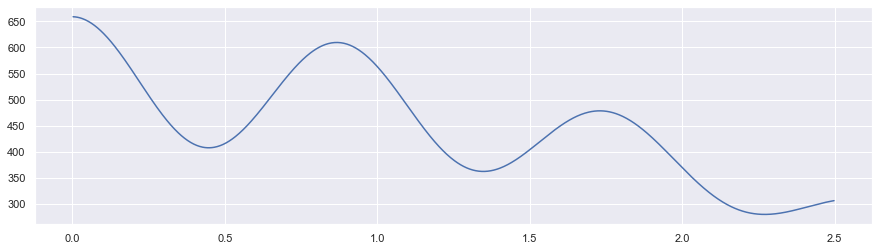

In [36]:
plt.plot(x[1:1000], xrecon[1:1000])

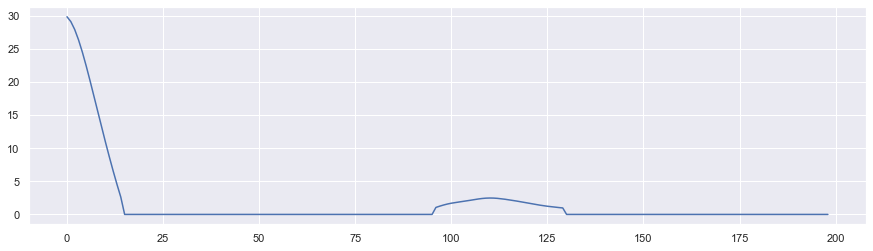

In [37]:
plt.plot(s[1:200])

Now we can get rid of the DC part.

In [39]:
s[0:25] = 0

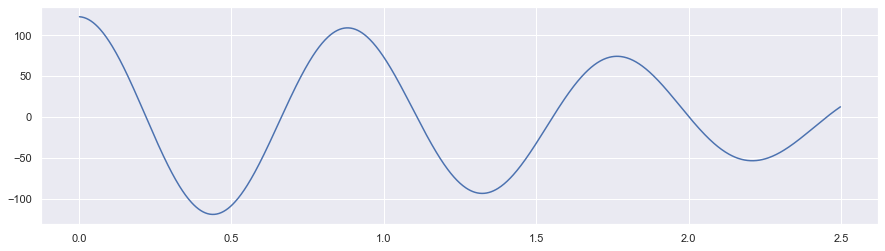

In [40]:
xrecon = idct(s)
plt.plot(x[1:1000], xrecon[1:1000])